In [1]:
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString, mapping
import geopandas as gpd
from ipyleaflet import *

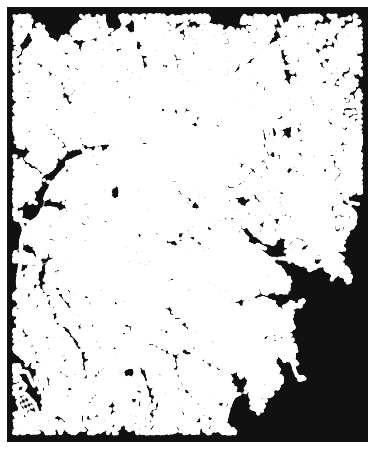

In [2]:
G = ox.load_graphml('data/g_unprojected.graphml')
fig, ax = ox.plot_graph(G)

In [3]:
nodes, edges = ox.graph_to_gdfs(G)
nodes

,y,x,street_count,highway,geometry
osmid,,,,,
26998731,0.352710,32.663264,4,NaN,POINT (32.66326 0.35271)
26998732,0.352850,32.666326,2,NaN,POINT (32.66633 0.35285)
26998735,0.355812,32.665092,3,NaN,POINT (32.66509 0.35581)
26998736,0.353255,32.663622,2,NaN,POINT (32.66362 0.35325)
26998738,0.356437,32.665388,4,NaN,POINT (32.66539 0.35644)
...,...,...,...,...,...
9155984271,0.237780,32.579959,2,NaN,POINT (32.57996 0.23778)
9161024754,0.360634,32.542839,2,NaN,POINT (32.54284 0.36063)
9162447190,0.397182,32.636225,2,NaN,POINT (32.63623 0.39718)


In [4]:
center = (0.32245219939201997, 32.59300521351633)
m = Map(center=center, basemap=basemaps.CartoDB.Positron, zoom=15)

In [5]:
#style for the destination marker
to_marker_style = AwesomeIcon(
    name='circle',
    icon_color='white',
    marker_color='red',
    spin=False
)
from_marker = Marker(location=center)
to_marker = Marker(location=center, icon=to_marker_style)

In [6]:
def set_nearest_node(marker):
 marker.nearest_node = ox.get_nearest_node(G, marker.location)
 return

In [7]:
path_layer_list = []
def handle_change_location(event, marker):
    event_owner = event['owner']
    event_owner.nearest_node = ox.get_nearest_node(G, event_owner.location)
    marker.nearest_node = ox.get_nearest_node(G, marker.location)
    
    shortest_path = nx.dijkstra_path(G, event_owner.nearest_node, marker.nearest_node, 
                                     weight='length')
    
    if len(path_layer_list) == 1:
        m.remove_layer(path_layer_list[0])
        path_layer_list.pop()
    
    shortest_path_points = nodes.loc[shortest_path]
    path = gpd.GeoDataFrame([LineString(shortest_path_points.geometry.values)], columns=['geometry'])
    path_layer = GeoData(geo_dataframe=path, style={'color':'black', 'weight':2})
    m.add_layer(path_layer)
    path_layer_list.append(path_layer)

In [8]:
from_marker.observe(lambda event: handle_change_location(event, to_marker), 'location')
to_marker.observe(lambda event: handle_change_location(event, from_marker), 'location')

In [9]:
m.add_layer(from_marker)
m.add_layer(to_marker)
set_nearest_node(from_marker)
set_nearest_node(to_marker)
m

/opt/conda/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


Map(center=[0.32245219939201997, 32.59300521351633], controls=(ZoomControl(options=['position', 'zoom_in_text'…